In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
x1=200;y1=200
train_datagen = image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=20)
valid_datagen = image.ImageDataGenerator(rescale=1./255)

train_data_path='/kaggle/input/waste-classification-data/DATASET/TRAIN'
train_generator = train_datagen.flow_from_directory(train_data_path ,target_size=(x1,y1),batch_size=64,class_mode='binary')

val_data='/kaggle/input/waste-classification-data/DATASET/TEST'
validation_generator = valid_datagen.flow_from_directory(val_data,target_size=(x1,y1),batch_size=64, class_mode='binary')



model = tf.keras.Sequential()
model.add(Xception(include_top = False, weights="imagenet", input_shape=(200, 200, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = 'accuracy')

history = model.fit(train_generator,
steps_per_epoch=8,
epochs=15,
verbose=1,
validation_data = validation_generator,
validation_steps=8)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


2022-11-30 20:46:07.842102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 20:46:07.944337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 20:46:07.945109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 20:46:07.947288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


2022-11-30 20:46:13.530694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-30 20:46:17.453506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 20s 1s/step - loss: 0.6581 - accuracy: 0.5781 - val_loss: 0.5986 - val_accuracy: 0.6719
Epoch 2/15
8/8 [==============================] - 10s 1s/step - loss: 0.5348 - accuracy: 0.7539 - val_loss: 0.5002 - val_accuracy: 0.7578
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.4457 - accuracy: 0.8672 - val_loss: 0.4513 - val_accuracy: 0.8320
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.3762 - accuracy: 0.8887 - val_loss: 0.4086 - val_accuracy: 0.8066
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.3369 - accuracy: 0.9062 - val_loss: 0.4105 - val_accuracy: 0.7871
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.3243 - accuracy: 0.8887 - val_loss: 0.3809 - val_accuracy: 0.8203
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.3031 - accuracy: 0.8887 - val_loss: 0.3488 - val_accuracy: 0.8340
Epoch 8/15
8/8 [==============================] -

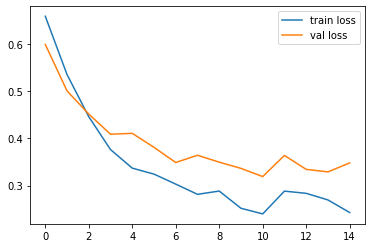

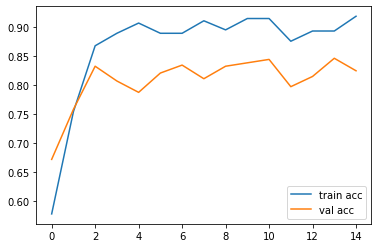

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.png')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend() 
plt.show()
plt.savefig('AccVal_acc.png')

In [6]:
model.evaluate(validation_generator)

40/40 [==============================] - 7s 167ms/step - loss: 0.3387 - accuracy: 0.8277


[0.33872297406196594, 0.8276959657669067]

In [7]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

40/40 [==============================] - 6s 134ms/step


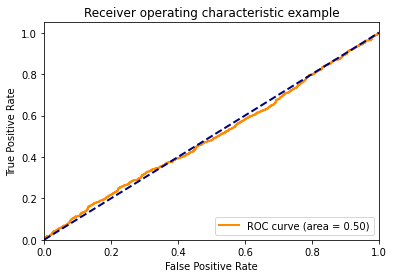

In [9]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
import numpy 
test_data='/kaggle/input/waste-classification-data/DATASET/TEST'
test_generator = valid_datagen.flow_from_directory(test_data,target_size=(x1,y1),batch_size=16, class_mode='binary',shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
# print(predictions)
predicted_classes = numpy.round(predictions)
# print(predicted_classes)

Found 2513 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [11]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

In [12]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           O       0.78      0.97      0.86      1401
           R       0.94      0.65      0.77      1112

    accuracy                           0.83      2513
   macro avg       0.86      0.81      0.82      2513
weighted avg       0.85      0.83      0.82      2513



In [13]:
model.save("Xception.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
